In this notebook we are going to generate the physiological regressors for one subject from the human connectome and compute their statistical maps.

In [1]:
import numpy as np
from nilearn.image import load_img
import sys
sys.path.append("../code")

In [15]:
bold_img = load_img("../data/ebach/sub-E1058/ses-01/func/sub-E1058_ses-01_task-rest_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
confounders = pd.read_csv("../data/ebach/sub-E1058/ses-01/func/sub-E1058_ses-01_task-rest_acq-mb3_desc-confounds_regressors.tsv", 
                    sep="\t")
motion = confounders.filter(regex="(trans|rot)_(x|y|z)")
n_samples = bold_img.shape[-1]
repetition_time = 2.0
frame_times = np.arange(n_samples)*repetition_time

In [3]:
n_samples

240

## Loading LOG files

In [5]:
from input_data import load_cmrr_info, load_cmrr_data
# So the second column to the respiratary signal, and the third one corresponds to ECG
info_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_Info.log"
ecg_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_ECG.log"
resp_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_RESP.log"
puls_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_PULS.log"

scan_traces, info_dict = load_cmrr_info(info_log)

print(info_dict)

ecg_signal,_ = load_cmrr_data(ecg_log, info_dict)
print(ecg_signal)

resp_signal,_ = load_cmrr_data(resp_log, info_dict)
print(resp_signal)

puls_signal,_ = load_cmrr_data(puls_log, info_dict)
print(puls_signal)


assert ecg_signal.shape[0] == resp_signal.shape[0]
assert ecg_signal.shape[0] == puls_signal.shape[0]

print(f"length of acquisition (should be ~ {info_dict['n_vols']*repetition_time}) =  {puls_signal.shape[0]/400}")

{'uuid': '034823c3-2e93-419c-b822-2bf382f43207', 'scan_date': '20191016_110935', 'log_version': 'EJA_1', 'n_slices': 69, 'n_vols': 240, 'n_echoes': 1, 'init_physio': 16086454, 'end_physio': 16282473, 'init_scan': 16090485, 'end_scan': 16282463, 'repetition_time': 800.0}
[[1815. 1858. 1979. 1980.]
 [2020. 1983. 1908. 1944.]
 [2188. 2061. 1910. 1966.]
 ...
 [2023. 2014. 1981. 2007.]
 [2020. 2011. 1983. 2008.]
 [2015. 2009. 1984. 2010.]]
[[356. ]
 [356. ]
 [356. ]
 ...
 [461. ]
 [459.5]
 [458. ]]
[[2983.]
 [3000.]
 [3017.]
 ...
 [2642.]
 [2627.]
 [2612.]]
length of acquisition (should be ~ 480.0) =  479.9475


In [6]:
from regressors import RetroicorPhysio, RVPhysio

In [7]:
retro_ecg = RetroicorPhysio(physio_rate=400, 
                            t_r=repetition_time, 
                            delta=200, high_pass=0.5, 
                            low_pass=3.0, order=2, 
                            columns="mean")
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

In [10]:
from nilearn.glm.first_level import FirstLevelModel

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["physio1", "physio2", "physio3", "physio4"])
dm.head()

/home/javi/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


,constant,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,physio1,physio2,physio3,physio4
0,1.0,0.000000e+00,0.000000,0.000000,0.000000,-0.000000,0.0,-0.999070,0.043107,-0.086133,-0.996284
1,1.0,0.000000e+00,0.040103,0.000020,-0.000497,-0.000000,0.0,0.972514,0.232844,0.452888,-0.891567
2,1.0,1.468590e-06,-0.004445,0.023110,-0.000041,-0.000122,0.0,0.997176,-0.075106,-0.149787,-0.988718
3,1.0,3.815470e-07,-0.015761,0.001249,-0.000207,-0.000069,0.0,0.863234,-0.504803,-0.871527,-0.490347
4,1.0,-1.084480e-02,0.011250,0.017716,-0.000300,-0.000133,0.0,0.521651,-0.853159,-0.890102,0.455761


In [13]:
first_level.fit(bold_img, design_matrices=dm)
res_dict = first_level.compute_contrast("physio1+physio2+physio3+physio4", stat_type="F", output_type="all")

/home/javi/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


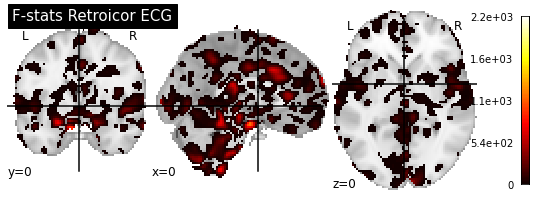

In [14]:
from nilearn import plotting
from nilearn.image import math_img
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor ECG")

## Compare this with using the signal in white matter and csf...

In [17]:
confounders.columns

Index(['csf', 'white_matter', 'global_signal', 'std_dvars', 'dvars',
       'framewise_displacement', 't_comp_cor_00', 't_comp_cor_01',
       't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05',
       'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
       'a_comp_cor_04', 'a_comp_cor_05', 'cosine00', 'cosine01', 'cosine02',
       'cosine03', 'cosine04', 'cosine05', 'non_steady_state_outlier00',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'],
      dtype='object')

In [20]:
# Contruct new design matrix
acompcor_regs = confounders.filter(regex="a_comp_cor")
dm_acompcor = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, acompcor_regs)), 
                           columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                           ["pc1", "pc2", "pc3", "pc4", "pc5", "pc6"])
dm_acompcor.head()

,constant,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,pc1,pc2,pc3,pc4,pc5,pc6
0,1.0,0.000000e+00,0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.000000e+00,0.040103,0.000020,-0.000497,-0.000000,0.0,0.022949,-0.100727,0.035222,0.004519,-0.106195,0.064459
2,1.0,1.468590e-06,-0.004445,0.023110,-0.000041,-0.000122,0.0,0.000639,-0.116768,-0.073370,-0.085192,-0.076436,0.054207
3,1.0,3.815470e-07,-0.015761,0.001249,-0.000207,-0.000069,0.0,-0.047871,-0.064692,0.066441,-0.052614,-0.000246,0.126864
4,1.0,-1.084480e-02,0.011250,0.017716,-0.000300,-0.000133,0.0,-0.057863,-0.045291,-0.055971,0.048377,0.057543,0.091329


In [21]:
first_level.fit(bold_img, design_matrices=dm_acompcor)
res_dict_acompcor = first_level.compute_contrast("pc1+pc2+pc3+pc4+pc5+pc6", stat_type="F", output_type="all")

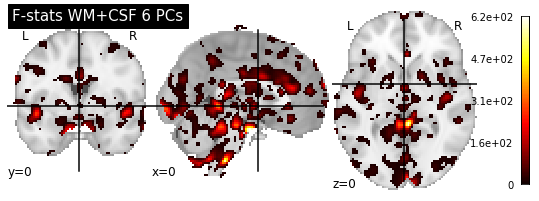

In [22]:
from nilearn import plotting
from nilearn.image import math_img
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), 
                       cut_coords=(0,0,0), title="F-stats WM+CSF 6 PCs")